In [210]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import datetime
import os
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [211]:
#https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [212]:
#input variables
path = 'image_arrays'

#model variables
test_size = 0.25
batch_size = 32 #32 == best, run 156079264
epoch_number = 50
validation_split = 0.15
learning_rate = 1e-3 #1e-4 stable, overtraining started after step 30, #1e-3 best, OT @ epoch 15

#architecture variables
"""
CNL1_filters = 32
CNL1_kernal_size = 5
MPL1_pool_size= (2,2)
MPL1_strides = 2
CNL2_filters = 64
CNL2_kernal_size = 5
MPL2_pool_size = (2,2)
MPL2_strides = 2
"""
#defined within because were modeling after a paper

'\nCNL1_filters = 32\nCNL1_kernal_size = 5\nMPL1_pool_size= (2,2)\nMPL1_strides = 2\nCNL2_filters = 64\nCNL2_kernal_size = 5\nMPL2_pool_size = (2,2)\nMPL2_strides = 2\n'

In [213]:
galaxyzoo = pd.read_csv("zoo2MainSpecz.csv", usecols=[8], nrows=10000)
Class = galaxyzoo["gz2class"].values
dictionary = {'A':int(2),'E':float(1),'S':float(0)}
#resave using my dictionary
target = np.empty((len(Class)))
for i in range(len(Class)):
    target[i] = int(dictionary[Class[i][0]])

In [214]:
#https://keras.io/preprocessing/image/

#datagen flow from directory wont work, need to create a different iterator. Have to combine with the targets somehow. 

#seems like a tf.data.Dataset is what we want... well, in the future atleast. lets right now get this working by doing something
#memory intensive.
#def generator(path,batchsize):
#    """
#    I want this function when called provide a 
#    """
#    image_list = os.listdir(path)
    

In [215]:
#this removes arrays that are only zeros. sometimes, I placed an array like this in the trainingset because removing it now is
#faster than having to deal with my download script throwing a fit and stopping. only needs to be run once of course.
#directory = os.listdir(path)
#for i in range(len(directory)):
#    array = np.load('{}\\{}'.format(path,directory[i]))
#    all_zeros = not np.any(array)
#    if all_zeros == True:
#        os.remove('{}\\{}'.format(path,directory[i]))

<h1>Prune the Training Set, Load it in...</h1>

In [216]:
#for i in range(len(directory)):
#    ith = (directory[i].split('_')[-1])
#    ith = ith.split('.')[0] #we want the str of what element this is so I can grab from my target array the correct label
#    ith = int(ith)
#    if target[ith] == 2:
#        os.remove('{}\\{}'.format(path,directory[i]))

Above removes arrays that are labeled as stars or artifacts. In principle, I could create a binary network that sorts galaxies
from stars, its just that the dataset I have right now is one of predominately galaxies. So we are losing the ability to sort 
out galaxies from stars and saying that we will address the problem earlier in our pipeline.

In [217]:
directory = os.listdir(path)
data = np.zeros((len(directory),64,64,5))
inbetween_target = np.zeros((len(directory)))
for i in range(len(directory)):
    ith = directory[i].split('_')[-1]
    ith = ith.split('.')[0] #we want the str of what element this is so I can grab from my target array the correct label
    ith = int(ith)
    array = np.load('{}\\{}'.format(path,directory[i])).astype(np.float32)
    data[i,:,:,:] = array
    inbetween_target[i] = target[ith]
target = inbetween_target
print(len(target))
print(np.shape(data))
print(len(directory))

9888
(9888, 64, 64, 5)
9888


In [218]:
train_images, test_images, train_target, test_target = train_test_split(data, target, test_size=test_size)

In [219]:
#https://arxiv.org/pdf/1903.05580.pdf hyperspectral online data augmentation paper

#https://github.com/jameslawlor/kaggle_galaxy_zoo/blob/master/galaxy_zoo_keras.ipynb
#good example for creating an iterator

In [220]:
#so this is pretty neat, you can create a keras callback to display on tensorboard using a simplified summary tf api

#and also this is an example of how to change the lr on the fly, which is pretty handy
#https://keras.io/callbacks/

logdir="summaries/scalars/" + str(datetime.datetime.now().timestamp())
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,
                                                   histogram_freq=1,
                                                   write_graph=False,
                                                   write_grads=True,)
                                                   #write_images=True)
"""
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
file_writer.set_as_default()

def lr_schedule(epoch):
"""
#Returns a custom learning rate that decreases as epochs progress.
"""
    learning_rate = 0.2
    if epoch > 10:
        learning_rate = 0.02
    if epoch > 20:
        learning_rate = 0.01
    if epoch > 50:
        learning_rate = 0.005

    tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
    return learning_rate

lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule)
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
"""


"\n    learning_rate = 0.2\n    if epoch > 10:\n        learning_rate = 0.02\n    if epoch > 20:\n        learning_rate = 0.01\n    if epoch > 50:\n        learning_rate = 0.005\n\n    tf.summary.scalar('learning rate', data=learning_rate, step=epoch)\n    return learning_rate\n\nlr_callback = keras.callbacks.LearningRateScheduler(lr_schedule)\ntensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)\n"

In [221]:
def create_model(learning_rate=learning_rate):
    
    model = keras.Sequential([])
    
    model.add(keras.layers.Conv2D(input_shape=(64,64,5),filters=32,kernel_size=6,padding='same',activation=tf.nn.relu))
    model.add(keras.layers.Dropout(rate=0.5))
    
    model.add(keras.layers.Conv2D(filters=64,kernel_size=5,padding='same',activation=tf.nn.relu))
    model.add(keras.layers.MaxPool2D(pool_size=2,))
    model.add(keras.layers.Dropout(rate=0.25)) #best = 0.25
    
    model.add(keras.layers.Conv2D(filters=128,kernel_size=2,padding='same',activation=tf.nn.relu))
    model.add(keras.layers.MaxPool2D(pool_size=2,))
    model.add(keras.layers.Dropout(rate=0.25)) #best = 0.25
    
    model.add(keras.layers.Conv2D(filters=128,kernel_size=3,padding='same',activation=tf.nn.relu))
    model.add(keras.layers.Dropout(rate=0.25)) #best = 0.35

    model.add(keras.layers.Flatten())
    
    model.add(keras.layers.Dense(units=64,activation=tf.nn.relu))
    model.add(keras.layers.Dropout(rate=0.5))
    model.add(keras.layers.Dense(units=2,activation=tf.nn.softmax))
    
    adam = keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=adam, loss='sparse_categorical_crossentropy',metrics=['accuracy',]) #auroc])
    return(model)

In [222]:
keras.backend.clear_session()
model = create_model(learning_rate = learning_rate)

In [223]:
#datagenerator will rotate flip and zoom my data for augmentations, b/c of cosmo principle I must be invarient to these.

#interestingly enough, there is no support for datagen right now with 5 channels:
#https://github.com/keras-team/keras/issues/4664
#that sucks, because if memory was an issue before, now I will have to default on doing my image roatations and zooms before
#hand, and that also takes up memory.

In [224]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        5792      
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        51264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       32896     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
__________

In [225]:
history = model.fit(train_images,
                    train_target,
                    batch_size=batch_size,
                    epochs=epoch_number,
                    validation_split=validation_split,
                    callbacks=[tensorboard_callback])#, lr_callback]) #and will display that on tensorboard too

Train on 6303 samples, validate on 1113 samples
Epoch 1/50
6303/6303 [==============================] - 222s 35ms/sample - loss: 0.6705 - acc: 0.6046 - val_loss: 0.6022 - val_acc: 0.6271
Epoch 2/50
6303/6303 [==============================] - 220s 35ms/sample - loss: 0.5444 - acc: 0.7274 - val_loss: 0.4943 - val_acc: 0.7889
Epoch 3/50
6303/6303 [==============================] - 220s 35ms/sample - loss: 0.5046 - acc: 0.7750 - val_loss: 0.4351 - val_acc: 0.8194
Epoch 4/50
6303/6303 [==============================] - 221s 35ms/sample - loss: 0.4685 - acc: 0.7985 - val_loss: 0.4646 - val_acc: 0.8113
Epoch 5/50
6303/6303 [==============================] - 221s 35ms/sample - loss: 0.4427 - acc: 0.8171 - val_loss: 0.4902 - val_acc: 0.7978
Epoch 6/50
6303/6303 [==============================] - 223s 35ms/sample - loss: 0.4211 - acc: 0.8280 - val_loss: 0.4647 - val_acc: 0.7942
Epoch 7/50
6303/6303 [==============================] - 220s 35ms/sample - loss: 0.4009 - acc: 0.8361 - val_loss: 0.43

In [226]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

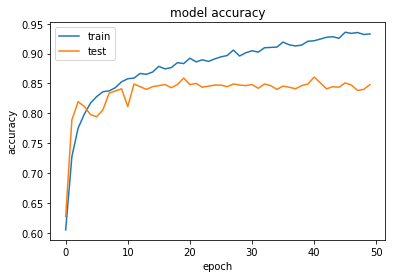

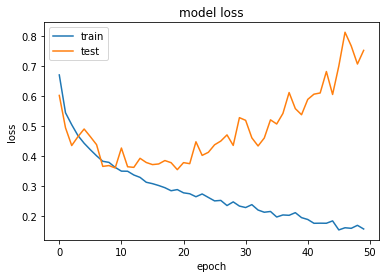

In [227]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('accuracy-2.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('loss-2.png')
plt.show()

In [228]:
#test_loss, test_acc = model.evaluate(test_images, test_target)
#print('Test accuracy:', test_acc)
#print('Test loss:', test_loss)

In [229]:
#all above are models using a different architecture. all below are comments from the current architecture

In [230]:
#source list
"""
https://fizzylogic.nl/2017/05/08/monitor-progress-of-your-keras-based-neural-network-using-tensorboard/

https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras

https://astrobites.org/2018/07/16/creating-a-more-general-deep-learning-algorithm-for-galaxies/
"""

'\nhttps://fizzylogic.nl/2017/05/08/monitor-progress-of-your-keras-based-neural-network-using-tensorboard/\n\nhttps://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras\n\nhttps://astrobites.org/2018/07/16/creating-a-more-general-deep-learning-algorithm-for-galaxies/\n'